In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission,\
    generate_wr_sim_with_wigrad_results
import coherent_modes_cpp as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple
from wigrad import Wiggler, WigglerRadiationSimulator

In [2]:
config_style_mesh = [
        [
            -0.0254,
            0.0254,
            128
        ],
        [
            -0.0254,
            0.0254,
            128
        ],
        [
            0.4,
            1.8,
            600
        ]
    ]
wiggler = Wiggler(K_peak=get_from_config("K_peak"))
rad_mesh_tuple = get_rad_mesh_tuple(config_style_mesh=config_style_mesh) 
x1d, y1d, l1d = rad_mesh_tuple
nx, ny, nl = [len(v) for v in rad_mesh_tuple]
def get_step(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)
dx, dy, dl = [get_step(v) for v in rad_mesh_tuple]
mesh = (rad_mesh_tuple[0][int(len(rad_mesh_tuple[0])/2):],
        rad_mesh_tuple[1][int(len(rad_mesh_tuple[1])/2):],
        rad_mesh_tuple[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
    spectral_transmission=None
)
wr_sim.calc_amplitude_on_meshgrid()
wr_sim.extend_results_using_symmetries()
spect_dist0 = wr_sim.get_spectral_distribution()
l1d0 = wr_sim.lambda_range

In [3]:
wr_sim.get_total_photon_flux(polarization='y')/wr_sim.get_total_photon_flux(polarization='x')

0.06819467361779116

In [4]:
config_style_mesh=[
        [
            -0.0254,
            0.0254,
            1024
        ],
        [
            -0.017960512242138304,
            0.017960512242138304,
            724
        ],
        [
            0.82,
            1.35,
            300
        ]
    ]
wr_sim = generate_wr_sim_with_wigrad_results(config_style_mesh=config_style_mesh)

In [5]:
ang_dist = wr_sim.get_angular_distribution()

In [6]:
spect_dist = wr_sim.get_spectral_distribution()

In [7]:
# from importlib import reload
# reload(matplotlib)
# from fur.path_assistant import get_plot_style_sheet
# import matplotlib as mpl
# mpl.use("pgf")
# plt.style.use(get_plot_style_sheet("prab"))
# plt.rc('pgf', preamble=\
#        r'\usepackage{amsmath}'
#        +r'\usepackage{unicode-math}'
#        +r'\usepackage{amsthm}'
#        +r'\setmainfont{Times New Roman}'
#        +r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
#        +r'\let\mathbb\relax'
#        +r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
#        +r'\usepackage{siunitx}'
#       +r'\usepackage{physics}'
# #         +r'\usepackage{mathptmx}'
#       +r'\newcommand{\None}{\langle\mathcal{N}_{\mathrm{s.e.}}\rangle}')
# plt.plot([1, 2, 3], label=r"$\dd\None/\dd\phi_x\dd\phi_y$ $(\SI{}{rad^{-2}})$")
# plt.xlabel(r' Wavelength ($\mu m$) $\epsilon_x$ $\beta_x$')
# plt.ylabel(r'Normal text ...')
# plt.legend()

In [8]:
# # from fur.path_assistant import get_plot_style_sheet
# # plt.style.use(get_plot_style_sheet("spectralangular"))
# # plt.rcParams["text.usetex"] =True
# # plt.rcParams["font.weight"] = 'bold'
# # plt.rc('text.latex', preamble=
# #        r'\usepackage{siunitx}'
# #       +r'\usepackage{physics}'
# #        +r'\usepackage{bm}'
# #       +r'\newcommand{\None}{\langle\mathcal{N}_{\mathrm{s.e.}}\rangle}'
# #       +r'\newcommand*{\myfont}{\fontfamily{ptm}\selectfont}')
# # plt.rcParams.update({'font.size': 28,
# #                      'legend.fontsize':22,
# #                      'errorbar.capsize':3})
# fig, axs = plt.subplots(2, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1]})
# ax2, ax1 = axs[0], axs[1]
# fs = 32

# pcm = ax1.pcolormesh(1000*wr_sim.x_2D, 1000*wr_sim.y_2D, ang_dist)
# asp = (ax1.get_ylim()[1]-ax1.get_ylim()[0])/(ax1.get_xlim()[1]-ax1.get_xlim()[0])
# ax1.set_aspect(1/np.sqrt(2)*1/asp)
# ax1.set_xlabel(r'$\phi_x$ $(\SI{}{mrad})$', fontsize=fs)
# ax1.set_ylabel(r'$\phi_y$ $(\SI{}{mrad})$', fontsize=fs)
# ax1.set_yticks(ticks=np.arange(-4,6,2))
# ax1.set_xticks(ticks=np.arange(-6,8,2))

# cb = fig.colorbar(pcm, ax=ax1, shrink=0.75,
#                   #orientation='horizontal',
#                   label=r"$\dd\None/\dd\phi_x\dd\phi_y$ $(\SI{}{rad^{-2}})$")
# ax = cb.ax
# text = ax.yaxis.label
# font = matplotlib.font_manager.FontProperties(size=fs)
# text.set_font_properties(font)

# ax2.set_xlabel('Wavelength $(\SI{}{\micro m})$', fontsize=fs)
# color = 'blue'
# ax2.plot(
#     l1d0,
#     1000*spect_dist0,
#     linewidth=4,color = color, label='No losses')
# color = 'tab:red'
# ax2.plot(
#     wr_sim.lambda_range,
#     1000*spect_dist,
#     linewidth=4,color = color, label='With losses')
# ax2.set_ylabel(
#     r'$\dv*{\None}{\lambda}$ $(\SI{}{nm^{-1}})$', fontsize=fs)
# ax2.set_ylim(0,1.1*max(1000*spect_dist0))
# ax2.legend()
# #asp = (ax2.get_ylim()[1]-ax2.get_ylim()[0])/(ax2.get_xlim()[1]-ax2.get_xlim()[0])
# #ax2.set_aspect(1/np.sqrt(2)*1/asp)
# fs2 = 28
# ax2.text(0.5,0.92,'Fundamental',fontsize=fs2,transform=ax2.transAxes)
# ax2.text(0.12,0.74,'Second harmonic',fontsize=fs2,transform=ax2.transAxes)
# ax2.set_yticks(ticks=np.arange(0,100,20))

# for axx, label in zip((ax2, ax1),('(a)', '(b)')):
#     bbox = axx.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     width, height = bbox.width, bbox.height
#     axx.text(-0.9/width, 1+0.25/height,label, transform=axx.transAxes,
#       fontsize=40, va='top', ha='left')
# plt.subplots_adjust(hspace=0.3)
# # plt.savefig(path_assistant.get_PRL_images_dir().fi("spectral_angular_distribution.png"),
# #             bbox_inches='tight',dpi=300)
# plt.show()

In [9]:
# from importlib import reload
# reload(matplotlib)

/home/ilobach/fur/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


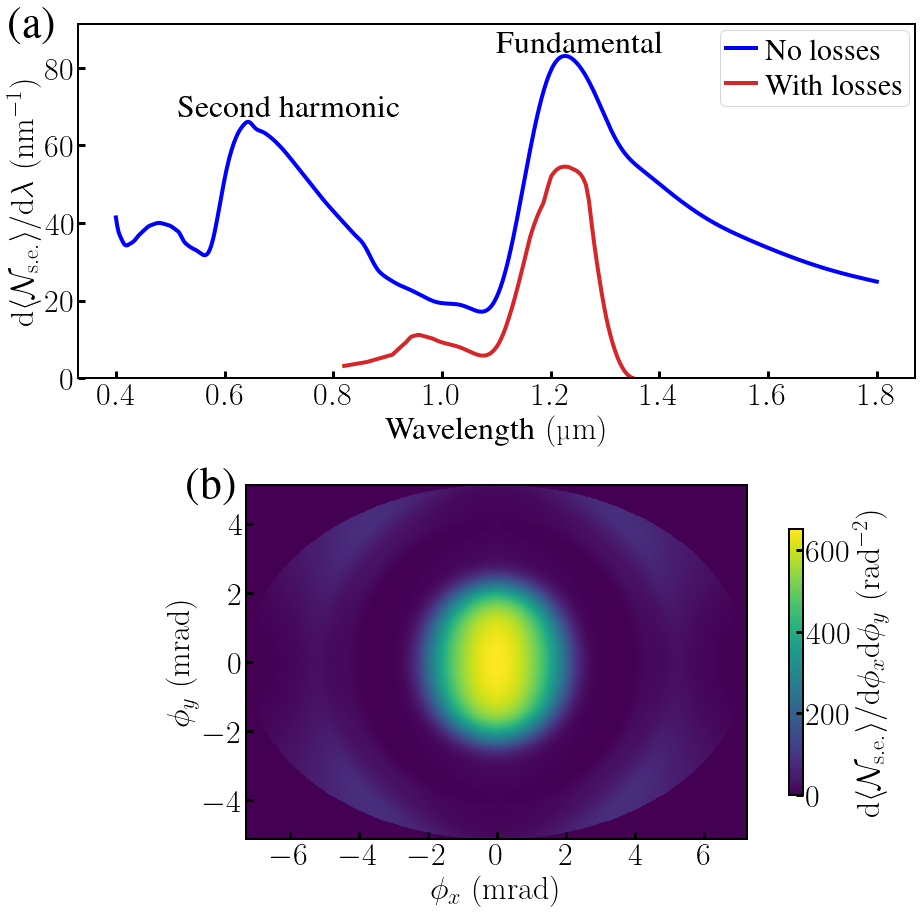

In [21]:
from fur.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("spectralangular"))
plt.rcParams["text.usetex"] =True
plt.rcParams["font.weight"] = 'normal'
plt.rc('text.latex', preamble=
       r'\usepackage{siunitx}'
      +r'\usepackage{physics}'
       +r'\usepackage{bm}'
      +r'\newcommand{\None}{\langle\mathcal{N}_{\mathrm{s.e.}}\rangle}'
#        +r'\usepackage{mathptmx}'
      +r'\newcommand*{\myfont}{\fontfamily{ptm}\selectfont}')
# plt.rcParams.update({'font.size': 28,
#                      'legend.fontsize':22,
#                      'errorbar.capsize':3})
fig, axs = plt.subplots(2, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1]})
ax2, ax1 = axs[0], axs[1]
fs = 32

pcm = ax1.pcolormesh(1000*wr_sim.x_2D, 1000*wr_sim.y_2D, ang_dist)
asp = (ax1.get_ylim()[1]-ax1.get_ylim()[0])/(ax1.get_xlim()[1]-ax1.get_xlim()[0])
ax1.set_aspect(1/np.sqrt(2)*1/asp)
ax1.set_xlabel(r'$\phi_x$ $(\SI{}{mrad})$', fontsize=fs)
ax1.set_ylabel(r'$\phi_y$ $(\SI{}{mrad})$', fontsize=fs)
ax1.set_yticks(ticks=np.arange(-4,6,2))
ax1.set_xticks(ticks=np.arange(-6,8,2))

cb = fig.colorbar(pcm, ax=ax1, shrink=0.75,
                  #orientation='horizontal',
                  label=r"$\dd\None/\dd\phi_x\dd\phi_y$ $(\SI{}{rad^{-2}})$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fs)
text.set_font_properties(font)

ax2.set_xlabel(r'{\myfont Wavelength} $(\SI{}{\micro m})$', fontsize=fs)
color = 'blue'
ax2.plot(
    l1d0,
    1000*spect_dist0,
    linewidth=4,color = color, label='{\myfont No losses}')
color = 'tab:red'
ax2.plot(
    wr_sim.lambda_range,
    1000*spect_dist,
    linewidth=4,color = color, label='{\myfont With losses}')
ax2.set_ylabel(
    r'$\dv*{\None}{\lambda}$ $(\SI{}{nm^{-1}})$', fontsize=fs)
ax2.set_ylim(0,1.1*max(1000*spect_dist0))
ax2.legend()
#asp = (ax2.get_ylim()[1]-ax2.get_ylim()[0])/(ax2.get_xlim()[1]-ax2.get_xlim()[0])
#ax2.set_aspect(1/np.sqrt(2)*1/asp)
fs2 = 32
ax2.text(0.5,0.92,'{\myfont Fundamental}',fontsize=fs2,transform=ax2.transAxes)
ax2.text(0.12,0.74,'{\myfont Second harmonic}',fontsize=fs2,transform=ax2.transAxes)
ax2.set_yticks(ticks=np.arange(0,100,20))

bbox = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
ax1.text(-1.1/width, 1+0.25/height, r'{\myfont (b)}', transform=ax1.transAxes,
  fontsize=44, va='top', ha='left')

bbox = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
ax2.text(-0.95/width, 1+0.25/height, r'{\myfont (a)}', transform=ax2.transAxes,
  fontsize=44, va='top', ha='left')


plt.subplots_adjust(hspace=0.3)
plt.savefig(path_assistant.get_PRL_images_dir().fi("spectral_angular_distribution.png"),
            bbox_inches='tight',dpi=300)
plt.show()

In [11]:
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

x21 = half_max_x(wr_sim.lambda_range, spect_dist)

fwhm = x21[1]-x21[0]
fwhm

0.14167140630901875

In [12]:
save_to_config("fundamental_fwhm", fwhm)